In [32]:
from __future__ import annotations
import logging
from dataclasses import dataclass
from operator import itemgetter
from typing import Tuple, List, Callable, TypeVar, Optional, Sequence, Iterable
import random
import numpy as np
from mingus.containers import Bar, Track, NoteContainer, Composition, Note
from mingus.midi.midi_file_out import write_Composition
from mingus.core.chords import from_shorthand
from mingus.core.progressions import determine
from fractions import Fraction
from mingus.extra import lilypond

## evolution.py

In [2]:
class Gene:
    def mutate(self, p: float = 1) -> Gene:
        raise NotImplementedError

    def crossover(self, gene: Gene) -> Tuple[Gene, Gene]:
        raise NotImplementedError


class Selection:
    def select(self, population: List[Gene], scores: List[float]) -> Tuple[Gene, float]:
        raise NotImplementedError
        
@dataclass(frozen=True)
class HarmonyGene(Gene):
    gene: List[str]
    alphabet: List[str]

    def __len__(self):
        return len(self.gene)

    def __str__(self):
        return f"HarmonyGene({str(self.gene)})"

    def __repr__(self):
        return str(self)

    def __getitem__(self, item):
        return self.gene[item]

    @staticmethod
    def initialize_population(n_population: int, gene_length: int, alphabet: List[str]) -> List[HarmonyGene]:
        return [
            HarmonyGene([random.choice(alphabet) for _ in range(gene_length)], alphabet) for _ in range(n_population)
        ]

    def crossover(self, gene: HarmonyGene) -> Tuple[HarmonyGene, HarmonyGene]:
        # single point crossover
        assert len(self) == len(gene)

        p = random.randint(1, len(self) - 1)

        return (
            HarmonyGene(self.gene[:p] + gene.gene[p:], self.alphabet),
            HarmonyGene(gene.gene[:p] + self.gene[p:], self.alphabet)
        )

    def mutate(self, p: float = 1) -> HarmonyGene:
        return HarmonyGene(
            [random.choice(self.alphabet) if random.random() < p else x for x in self.gene],
            self.alphabet
        )
    
    
class Callback:
    def on_begin(self):
        pass

    def on_end(self):
        pass

    def on_epoch_end(self, best_solution: Gene, best_score: float, epoch: int) -> bool:
        return False


class EarlyStopping(Callback):
    def __init__(self, patience):
        self.patience = patience
        self.best_score = None
        self.not_improved = 0

    def on_begin(self):
        self.not_improved = 0

    def on_epoch_end(self, best_solution: Gene, best_score: float, epoch: int) -> bool:
        if self.best_score is None:
            self.best_score = best_score

        if best_score <= self.best_score:
            self.not_improved += 1
            if self.not_improved >= self.patience:
                logger.info(f"The fitness has not improved for {self.patience} epochs. Stopping training at epoch {epoch}")
                return True
        else:
            self.not_improved = 0
            self.best_score = best_score


@dataclass
class TournamentSelection(Selection):
    k: int

    def select(self, population: List[Gene], scores: List[float]) -> Tuple[Gene, float]:
        return max(random.choices(list(zip(population, scores)), k=self.k), key=itemgetter(1))

In [3]:
GeneType = TypeVar('GeneType', bound=Gene)

In [4]:
def genetic_algorithm(
        optimize_func: Callable[[GeneType], float],
        initial_population: List[GeneType],
        selection: Selection,
        p_crossover: float,
        p_mutation: float,
        epochs: int,
        p_location_mutation: Optional[float] = None,
        callbacks: Sequence[Callback] = tuple()
) -> Tuple[GeneType, float]:
    for callback in callbacks:
        callback.on_begin()

    if p_location_mutation is None:
        p_location_mutation = 1 / len(initial_population[0])

    population = initial_population
    scores = list(map(optimize_func, initial_population))

    best_idx = np.argmax(scores)
    best_solution = population[best_idx]
    best_score = scores[best_idx]

    for j in range(epochs):
        next_population = []
        next_scores = []

        for i in range(0, len(population), 2):
            parent_1, score_1 = selection.select(population, scores)
            parent_2, score_2 = selection.select(population, scores)

            if random.random() < p_crossover:
                children = parent_1.crossover(parent_2)
                child_scores = (None, None)
            else:
                children = (parent_1, parent_2)
                child_scores = (score_1, score_2)

            for child, score in list(zip(children, child_scores))[:int(i + 1 < len(population)) + 1]:
                if random.random() < p_mutation:
                    child = child.mutate(p=p_location_mutation)
                    score = None

                if score is None:
                    score = optimize_func(child)

                next_population.append(child)
                next_scores.append(score)

                if score > best_score:
                    best_score = score
                    best_solution = child

        population = next_population
        scores = next_scores

        if any(callback.on_epoch_end(best_solution, best_score, j) for callback in callbacks):
            break

    for callback in callbacks:
        callback.on_end()

    return best_solution, best_score

## utils.py

In [5]:
good_progressions = [['I', 'IV', 'V', 'I', 'I'],
                     ['I', 'IV', 'vi', 'V', 'I'],
                     ['I', 'IV', 'I', 'V', 'I'],
                     ['I', 'V', 'IV', 'V', 'I'],
                     ['I', 'vi', 'IV', 'V', 'I'],
                     ['I', 'V', 'vi', 'IV', 'I']]

In [6]:
def get_chord_notes(chord: str) -> List[str]:
    return from_shorthand(chord)


def note_match_fitness(chord: str, notes: Iterable[str]) -> float:
    chord_notes = set(get_chord_notes(chord))
    notes = set(map(lambda x: Note(x).name, notes))
    return len(chord_notes.intersection(notes)) / len(chord_notes)


def note_mismatch_penalty(chord: str, notes: Iterable[str]) -> float:
    chord_notes = set(get_chord_notes(chord))
    notes = set(map(lambda x: Note(x).name, notes))
    return len(chord_notes.difference(notes)) / len(chord_notes)

def chord_progression_fitness(chords: List[str], key: str) -> float:
    progression = []
    for chord in chords:
        determined_chord = determine(get_chord_notes(chord), key, True)[0]
        progression.append(determined_chord)

    if progression in good_progressions:
        return 0.5
    elif progression[-2:] in [['V', 'I'], ['IV', 'I']]:
        return 0.25
    elif progression[-1] == 'I':
        return 0.1
    else:
        return -0.5

## mingus_test.py

In [8]:
def dot(x: Fraction) -> Fraction:
    return x + x / 2


def to_mingus(x: Fraction) -> float:
    return float(1 / x)

In [9]:
whole = Fraction(1)
half = Fraction(1, 2)
quarter = Fraction(1, 4)
eighth = Fraction(1, 8)
sixteenth = Fraction(1, 16)

test_melody = (
    (
        ("C-5", dot(eighth)),
        ("C-5", sixteenth)
    ),
    (
        ("D-5", quarter),
        ("C-5", quarter),
        ("F-5", quarter)
    ),
    (
        ("E-5", half),
        ("C-5", dot(eighth)),
        ("C-5", sixteenth)
    ),
    (
        ("D-5", quarter),
        ("C-5", quarter),
        ("G-5", quarter)
    ),
    (
        ("F-5", half),
    )
)


test_chords = (
    "",
    "F",
    "C",
    "C",
    "F"
)

In [33]:
def write_composition(melody: Iterable[Tuple[Tuple[str, Fraction]]], chords: Iterable[str],
                      filename: str = "test.midi"):
    # generating midi
    melody_track = Track()
    chord_track = Track()

    for chord, bar in zip(chords, melody):
        # time signature is taken according to the notes
        bar_length = sum(note[1] for note in bar)
        ratio = bar_length.as_integer_ratio()

        note_bar = Bar(meter=ratio)
        chord_bar = Bar(meter=ratio)

        # adding notes
        for note, duration in bar:
            if not note_bar.place_notes(note, to_mingus(duration)):
                raise ValueError("more notes than fit in a bar")

        if not chord_bar.place_notes(NoteContainer().from_chord_shorthand(chord) if chord else None,
                                     to_mingus(bar_length)):
            raise ValueError("more notes than fit in a bar")

        melody_track.add_bar(note_bar)
        chord_track.add_bar(chord_bar)

    composition = Composition()
    composition.add_track(melody_track)
    composition.add_track(chord_track)

    write_Composition(filename, composition)
    return composition

## test_music_evolution.py

In [11]:
def fitness(gene: HarmonyGene, melody: Iterable[Tuple[Tuple[str, Fraction]]], key: str) -> float:
    melody_notes = set(note[0] for bar in melody for note in bar)

    fitness = 0
    for chord, bar in zip(gene, melody):
        bar_notes = set(note[0] for note in bar)
        fitness += note_match_fitness(chord, bar_notes)
        fitness -= 0.7 * note_mismatch_penalty(chord, bar_notes)
        fitness -= 0.3 * note_mismatch_penalty(chord, melody_notes)

    fitness += chord_progression_fitness(gene.gene, key)

    return fitness

In [34]:
write_composition(test_melody, test_chords, "correct.midi")

# alphabet = get_notes("F")
# alphabet = ['Gb', 'Db', 'Ab', 'Eb', 'Bb', 'F', 'C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#', 'D#', 'A#']
# alphabet += [a + "m" for a in alphabet]

# only diatonic chords
alphabet = ["F", "Gm", "Am", "Bb", "C", "Dm", "Edim"]

key = "F"
n_population = len(test_chords)

print("Alphabet", alphabet)
initial_pop = HarmonyGene.initialize_population(n_population * 10, n_population, alphabet)
generated_chords, score = genetic_algorithm(
    lambda x: fitness(x, test_melody, key),
    initial_pop,
    TournamentSelection(5),
    p_crossover=0.8,
    p_mutation=0.3,
    epochs=5000
)
print("Best score:", score)
print("Generated chords", generated_chords)
gen_comp = write_composition(test_melody, generated_chords, "generated.midi")

Alphabet ['F', 'Gm', 'Am', 'Bb', 'C', 'Dm', 'Edim']
Best score: 1.0833333333333335
Generated chords HarmonyGene(['C', 'F', 'C', 'C', 'F'])


# Sample output visualised

In [37]:
comp = lilypond.from_Composition(gen_comp)
print(comp)
lilypond.to_png(comp, "gen_comp")

\header { title = "Untitled" composer = "" opus = "" } { { \time 1/4 c''8. c''16 } { \time 3/4 d''4 c''4 f''4 } { e''2 c''8. c''16 } { d''4 c''4 g''4 } { \time 1/2 f''2 } } { { \time 1/4 <c' e' g'>4 } { \time 3/4 <f' a' c''>2. } { <c' e' g'>2. } { <c' e' g'>2. } { \time 1/2 <f' a' c''>2 } }
Executing: lilypond -fpng -o "gen_comp" "gen_comp.ly"


True

##### before:
<div>
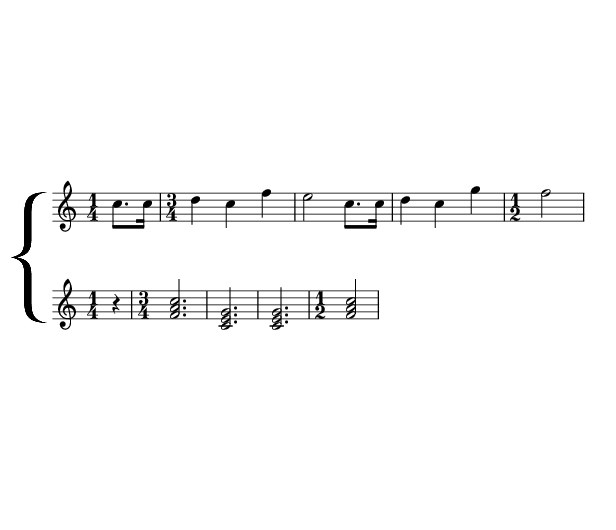
</div>

##### generated chords:
<div>
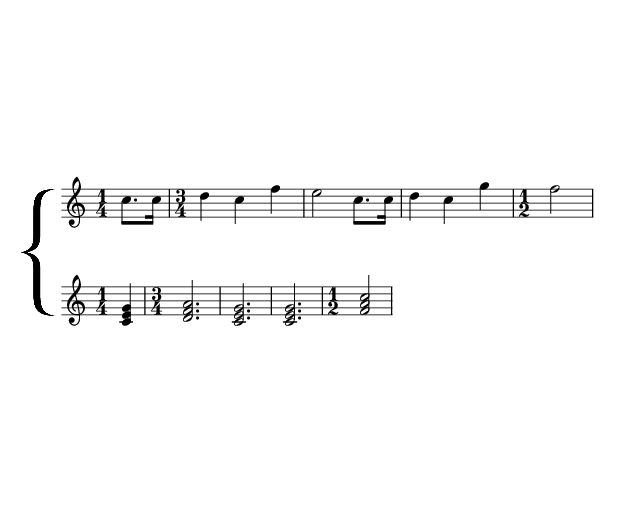
</div>